# Quasi-criticality in the Cortex

In [1]:
'''Setup notebook environment -q flag suppresses output, if you want to see it, remove the -q flag'''
# %pip install -r requirements.txt -q
from utils.plotting_utils import *
from utils.data_utils import *
from utils.utils import simulate
from branching import BranchingNeurons
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
if os.path.exists('data/branching_data.csv'):
    data = load_data('data/branching_data.csv')
else:
    kwargs = {
        'N': 2500,
        'max_neighbors': 15,
        'visual': False,
    }
    data = simulate(BranchingNeurons, n_runs=3, duration=10000, **kwargs)


In [ ]:
def get_max__length(data):
    max_length = 0
    for j in range(len(data)):
        for i in range(len(data[j])):
            if len(data[j][i]) > max_length:
                max_length = len(data[j][i])
    return max_length

def pad_data_to_max_length(data, max_length):
    for j in range(len(data)):
        for i in range(len(data[j])):
            if len(data[j][i]) < max_length:
                data[j][i] = np.pad(data[j][i], (0, max_length - len(data[j][i])), 'constant', constant_values=(0, 0))
    return data

homogenous_data = np.array(pad_data_to_max_length(data, get_max__length(data)))

In [ ]:
duration_data = homogenous_data[:,0,:]
size_data = homogenous_data[:,1,:]

In [ ]:
flattened = size_data.flatten()
plt.hist(flattened, histtype='step', density=True)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:

# duration_data = duration_data.sort(axis=1)
# size_data = size_data.sort(axis=1)
# mean_duration = np.mean(duration_data, axis=0)
# mean_size = np.mean(size_data, axis=0)
mean_duration = duration_data[0]
mean_size = size_data[0]

plt.scatter(mean_duration, mean_size)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [2]:
settings = [
    {"name": "round_spiral", "params": {"height": 4, "refractory_period": 5, "probability_of_spontaneous_activity": 0.02, "max_distance": 3, "visualize": True, "random_connection": False}},
    {"name": "pulse_wave", "params": {"height": 5, "refractory_period": 4, "probability_of_spontaneous_activity": 0.03, "max_distance": 3, "visualize": True, "random_connection": False}},
    {"name": "synchronous", "params": {"height": 3, "refractory_period": 5, "probability_of_spontaneous_activity": 0.015, "max_distance": 2.5, "visualize": True, "random_connection": True}},
    {"name": "oscillatory", "params": {"height": 2, "refractory_period": 4, "probability_of_spontaneous_activity": 0.02, "max_distance": 3, "visualize": True, "random_connection": False}},
    {"name": "repeating", "params": {"height": 2, "refractory_period": 4, "probability_of_spontaneous_activity": 0.02, "max_distance": 3, "visualize": True, "random_connection": True}},
    {"name": "random", "params": {"height": 5, "refractory_period": 5, "probability_of_spontaneous_activity": 0.02, "max_distance": 3, "visualize": True, "random_connection": False}}
    ]

In [ ]:
for setting in settings:
    btw = BTW(grid_size=[50, 50], **setting['params'])
    btw.init_grid("random", 4)
    btw.run(10000)
    path = f"data/spikes_btw_{setting['name']}.csv"
    btw.write_data(path)

9.09262577891767
0.4827481027326525
0.06316052188271712
0.16132540659386724
0.2667088157865192
0.35978900657971213
6.338509523744631
0.6100247183009285
2.839344748751311
4.856265046570313
0.020618131096773833
0.012045103579674959


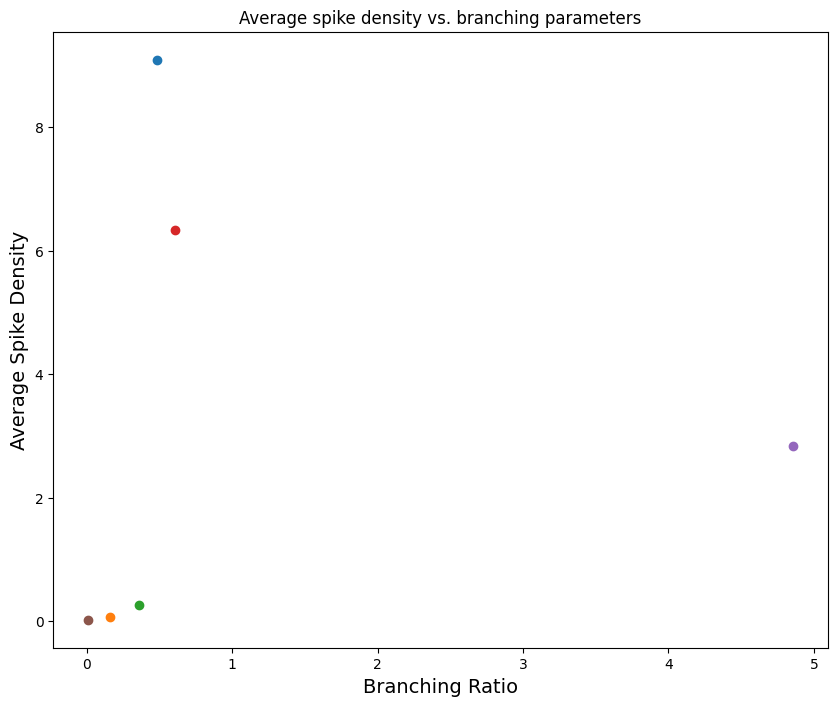

In [3]:
# Plot avg_spike_density vs. m
paths = [f"data/spikes_btw_{setting['name']}.csv" for setting in settings]
refractory_periods = [setting['params']['refractory_period'] for setting in settings]
size = 50
spike_density_plot(paths, size, refractory_periods)
